<a href="https://colab.research.google.com/github/parjhanya/Image_Classification/blob/master/CIFAR_10_Keras_Transfer_learning_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
from keras import Sequential
from keras.applications import VGG19,ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
#Import dataset
from keras.datasets import cifar10

In [ ]:
#Divide the data in Train, Validation and Test Datasets
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [ ]:
#Print the dimensions of the datasets
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [ ]:
#One hot encode the labels.Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [ ]:
# Print the dimensions one more time
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [ ]:
#Data Augmentation Function: Let's define an instance of the ImageDataGenerator class and set the parameters.We have to instantiate for the Train,Validation and Test datasets
train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 


In [ ]:
#Fit the augmentation method to the data

train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [ ]:
lrr= ReduceLROnPlateau(
                       monitor='val_acc', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate 

In [ ]:
#Build the model

#The first base model used is VGG19. The pretrained weights from the imagenet challenge are used
base_model_1 = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

#For the 2nd base model we will use Resnet 50 and compare the performance against the previous one.The hypothesis is that Resnet 50 should perform better because of its deeper architecture
base_model_2 = ResNet50(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])


80142336/80134624 [==============================] - 61s 1us/step


C:\Users\M1059834\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 66s 1us/step


In [ ]:
#Lets add the final layers to these base models where the actual classification is done in the dense layers

model_1= Sequential()
model_1.add(base_model_1) #Adds the base model (in this case vgg19 to model_1)
model_1.add(Flatten()) #Since the output before the flatten layer is a matrix we have to use this function to get a vector of the form nX1 to feed it into the fully connected layers


In [ ]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Add the Dense layers along with activation and batch normalization
model_1.add(Dense(1024,activation=('relu'),input_dim=512))
model_1.add(Dense(512,activation=('relu'))) 
model_1.add(Dense(256,activation=('relu'))) 
#model_1.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_1.add(Dense(128,activation=('relu')))
#model_1.add(Dropout(.2))
model_1.add(Dense(10,activation=('softmax'))) #This is the classification layer


In [ ]:
#Check final model summary
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [ ]:
batch_size= 32
epochs=10

In [ ]:
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


In [ ]:
#Compile the model

model_1.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_1.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),validation_steps=250,
                      callbacks=[lrr],verbose=1)


Epoch 1/10
1093/1093 [==============================] - 1694s 2s/step - loss: 2.0076 - accuracy: 0.2477 - val_loss: 1.4818 - val_accuracy: 0.5008
Epoch 2/10


C:\Users\M1059834\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1093/1093 [==============================] - 1806s 2s/step - loss: 0.9827 - accuracy: 0.6670 - val_loss: 0.7066 - val_accuracy: 0.7355
Epoch 3/10
1093/1093 [==============================] - 2061s 2s/step - loss: 0.6989 - accuracy: 0.7652 - val_loss: 0.3723 - val_accuracy: 0.7751
Epoch 4/10
1093/1093 [==============================] - 2110s 2s/step - loss: 0.5731 - accuracy: 0.8067 - val_loss: 0.7232 - val_accuracy: 0.7945
Epoch 5/10
1093/1093 [==============================] - 1935s 2s/step - loss: 0.4937 - accuracy: 0.8340 - val_loss: 0.4559 - val_accuracy: 0.8174
Epoch 6/10
1093/1093 [==============================] - 1744s 2s/step - loss: 0.4322 - accuracy: 0.8528 - val_loss: 0.6064 - val_accuracy: 0.8157
Epoch 7/10
1093/1093 [==============================] - 1723s 2s/step - loss: 0.3842 - accuracy: 0.8708 - val_loss: 0.5185 - val_accuracy: 0.8310
Epoch 8/10
1093/1093 [==============================] - 1724s 2s/step - loss: 0.3360 - accuracy: 0.8866 - val_loss: 0.3210 - val_accura

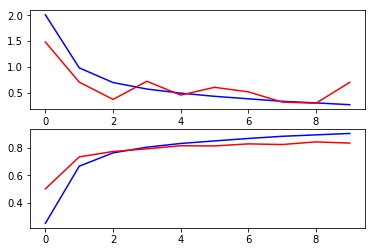

In [ ]:
#Plot the training and valiation loss

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(model_1.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model_1.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model_1.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model_1.history.history['val_accuracy'],color='r',label='Validation Accuracy')